
<div style="text-align:center; font-size:32px;">
XGB_boost Model
</div>

---

### Import necessary librairies

In [29]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,root_mean_squared_error
from xgboost import XGBRegressor

In [30]:
#parameters of forecast
date_end_real_data = '2025-11'    #to change
date_debut_forecast = '2025-12'  #to change
date_end_forecast = '2026-12'    #to change
n_months_forecast = 12           #to change

## Data prep
---

In [31]:
# *
# upload the excel file 
df_excel_complete = pd.read_excel('Consolidado_python_Eloi.xlsx')

# convert to CSV so it can be processed in python
df_excel_complete.to_csv('Consolidado_python_Eloi.csv', index=False)

# Visual check of the conversion
df_excel_complete


,Date,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_Rate,Euribor1year
0,201911,NaN,0.80,0.2,6.7,0.35,-0.4013,-0.2720
1,201912,NaN,0.80,0.4,6.8,0.41,-0.3947,-0.2614
2,202001,NaN,-4.20,0.8,6.8,0.37,-0.3911,-0.2534
3,202002,NaN,-4.20,0.5,6.5,0.25,-0.4088,-0.2881
4,202003,NaN,-4.20,0.1,5.8,0.71,-0.4166,-0.2656
...,...,...,...,...,...,...,...,...
93,202708,NaN,2.08,NaN,NaN,NaN,NaN,NaN
94,202709,NaN,2.08,NaN,NaN,NaN,NaN,NaN
95,202710,NaN,2.14,NaN,NaN,NaN,NaN,NaN
96,202711,NaN,2.14,NaN,NaN,NaN,NaN,NaN


In [32]:
# columns of the CSV file 
df_excel_complete.columns

Index(['Date', 'Bananas', 'GDP', 'Inflation', 'Unemployment_Rate',
       'LT_Interest_Rate', 'ST_Interest_Rate', 'Euribor1year'],
      dtype='object')

In [33]:
# Sélections of necessary columns
columns_needed = ['Date',
                  'Bananas',
                  'GDP',
                  'Inflation',
                  'Unemployment_Rate',
                  'LT_Interest_Rate',
                  'ST_Interest_Rate',
                  'Euribor1year']

df_reduced=df_excel_complete[columns_needed]
df_reduced.head()


,Date,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_Rate,Euribor1year
0,201911,NaN,0.8,0.2,6.7,0.35,-0.4013,-0.2720
1,201912,NaN,0.8,0.4,6.8,0.41,-0.3947,-0.2614
2,202001,NaN,-4.2,0.8,6.8,0.37,-0.3911,-0.2534
3,202002,NaN,-4.2,0.5,6.5,0.25,-0.4088,-0.2881
4,202003,NaN,-4.2,0.1,5.8,0.71,-0.4166,-0.2656


In [34]:
# Extrqction of year and month (supposing the format is 'YYYYMM')
df_reduced['Date'] = pd.to_datetime(df_reduced['Date'], format='%Y%m')

# put DATE in index
df_reduced = df_reduced.set_index('Date')
df_reduced

,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_Rate,Euribor1year
Date,,,,,,,
2019-11-01,NaN,0.80,0.2,6.7,0.35,-0.4013,-0.2720
2019-12-01,NaN,0.80,0.4,6.8,0.41,-0.3947,-0.2614
2020-01-01,NaN,-4.20,0.8,6.8,0.37,-0.3911,-0.2534
2020-02-01,NaN,-4.20,0.5,6.5,0.25,-0.4088,-0.2881
2020-03-01,NaN,-4.20,0.1,5.8,0.71,-0.4166,-0.2656
...,...,...,...,...,...,...,...
2027-08-01,NaN,2.08,NaN,NaN,NaN,NaN,NaN
2027-09-01,NaN,2.08,NaN,NaN,NaN,NaN,NaN
2027-10-01,NaN,2.14,NaN,NaN,NaN,NaN,NaN


In [35]:
#check data types
print(df_reduced.dtypes)

Bananas              float64
GDP                  float64
Inflation            float64
Unemployment_Rate    float64
LT_Interest_Rate     float64
ST_Interest_Rate     float64
Euribor1year         float64
dtype: object


In [36]:
# separation of the real data and the data that is forecast
df_known = df_reduced.loc[:date_end_real_data]                               # to change 

# verification of the type
print(df_known.dtypes)

# Séparation train/test on data we know 
train_size = int(len(df_known) * 0.8)
train, test = df_known[:train_size], df_known[train_size:]
train = train.dropna()
# Data to predict 
df_forecast = df_reduced.loc[date_debut_forecast:date_end_forecast]                       

# Vérification
print(train.shape, test.shape)
print(df_forecast.shape)

Bananas              float64
GDP                  float64
Inflation            float64
Unemployment_Rate    float64
LT_Interest_Rate     float64
ST_Interest_Rate     float64
Euribor1year         float64
dtype: object
(46, 7) (15, 7)
(13, 7)



---


## Feature prep


---


In [37]:
#define X and Y for the model
features = ['GDP', 'Inflation', 'Unemployment_Rate', 'LT_Interest_Rate', 'ST_Interest_Rate', 'Euribor1year']
X_train = train[features]
y_train = train['Bananas']
X_test = test[features]
y_test = test['Bananas']

In [38]:
X_train

,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_Rate,Euribor1year
Date,,,,,,
2020-11-01,0.2,-0.4,7.2,0.07,-0.5209,-0.4806
2020-12-01,0.2,-0.3,6.9,0.03,-0.5381,-0.4966
2021-01-01,-2.8,0.2,6.9,0.03,-0.5472,-0.5047
2021-02-01,-2.8,0.3,6.8,0.16,-0.5411,-0.5009
2021-03-01,-2.8,0.1,6.7,0.23,-0.5391,-0.4867
2021-04-01,4.6,-0.1,7.2,0.35,-0.5382,-0.4835
2021-05-01,4.6,0.5,7.3,0.53,-0.5401,-0.4806
2021-06-01,4.6,-0.6,7.1,0.43,-0.5429,-0.4839
2021-07-01,3.6,1.1,6.8,0.27,-0.5448,-0.4907


In [39]:
y_train

Date
2020-11-01    0.035473
2020-12-01    0.037405
2021-01-01    0.035782
2021-02-01    0.033814
2021-03-01    0.031089
2021-04-01    0.025261
2021-05-01    0.021414
2021-06-01    0.019845
2021-07-01    0.021488
2021-08-01    0.022337
2021-09-01    0.022674
2021-10-01    0.023827
2021-11-01    0.024668
2021-12-01    0.025587
2022-01-01    0.022777
2022-02-01    0.023074
2022-03-01    0.023487
2022-04-01    0.026882
2022-05-01    0.027910
2022-06-01    0.029487
2022-07-01    0.030301
2022-08-01    0.034625
2022-09-01    0.035556
2022-10-01    0.038039
2022-11-01    0.042859
2022-12-01    0.047126
2023-01-01    0.049350
2023-02-01    0.054083
2023-03-01    0.059178
2023-04-01    0.064044
2023-05-01    0.066951
2023-06-01    0.069564
2023-07-01    0.071845
2023-08-01    0.074210
2023-09-01    0.072171
2023-10-01    0.073208
2023-11-01    0.071678
2023-12-01    0.069690
2024-01-01    0.055859
2024-02-01    0.050661
2024-03-01    0.051283
2024-04-01    0.048583
2024-05-01    0.046140
2024-0

---

## Final version of XGB_boost 

---

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import shap


In [41]:
# Function to create lag features
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog={}):
    df_lag = df.copy()
    
    # Target lags
    for lag in lags_target:
        df_lag[f'{target_col}_lag{lag}'] = df_lag[target_col].shift(lag)
    
    # Exogenous lags
    for feature, lags in lags_exog.items():
        for lag in lags:
            df_lag[f'{feature}_lag{lag}'] = df_lag[feature].shift(lag)
    
    df_lag = df_lag.dropna()
    return df_lag


lags_target = [1, 2, 3]
lags_exog = {
    'ST_Interest_Rate': [1, 2],
    'GDP': [1, 2]
}

df_lag = create_lag_features(
    df_known,
    'Bananas',
    lags_target=lags_target,
    lags_exog=lags_exog
)


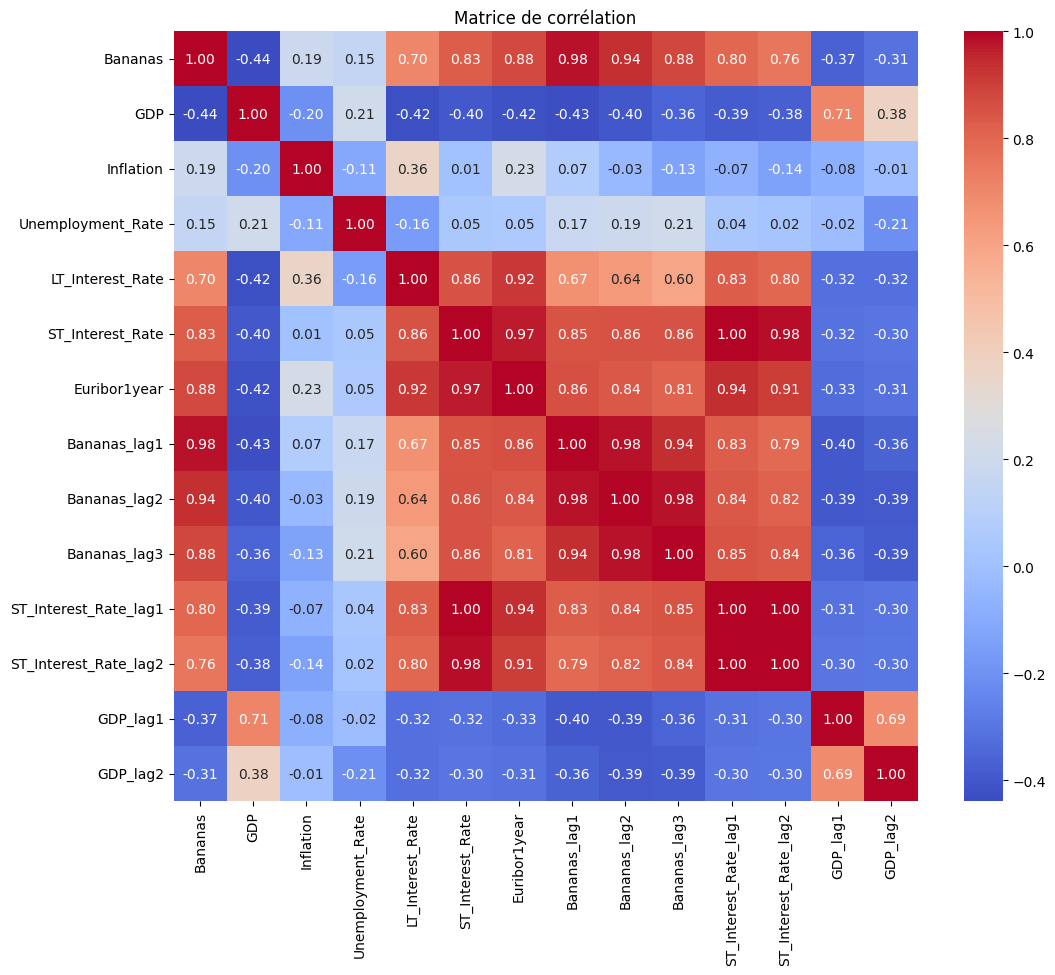

In [42]:
#Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df_lag.corr(), cmap='coolwarm',annot=True, fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()


In [43]:
#definition of the features
features = (
    ['GDP', 'Inflation', 'Unemployment_Rate',
     'LT_Interest_Rate', 'ST_Interest_Rate', 'Euribor1year']
    + [f'Bananas_lag{lag}' for lag in lags_target]
    + [f'{feat}_lag{lag}' for feat, lags in lags_exog.items() for lag in lags]
)

X_all = df_lag[features]
y_all = df_lag['Bananas']



Fold 1 RMSE : 0.0063
Fold 2 RMSE : 0.0252
Fold 3 RMSE : 0.0111
Fold 4 RMSE : 0.0063
Fold 5 RMSE : 0.0025


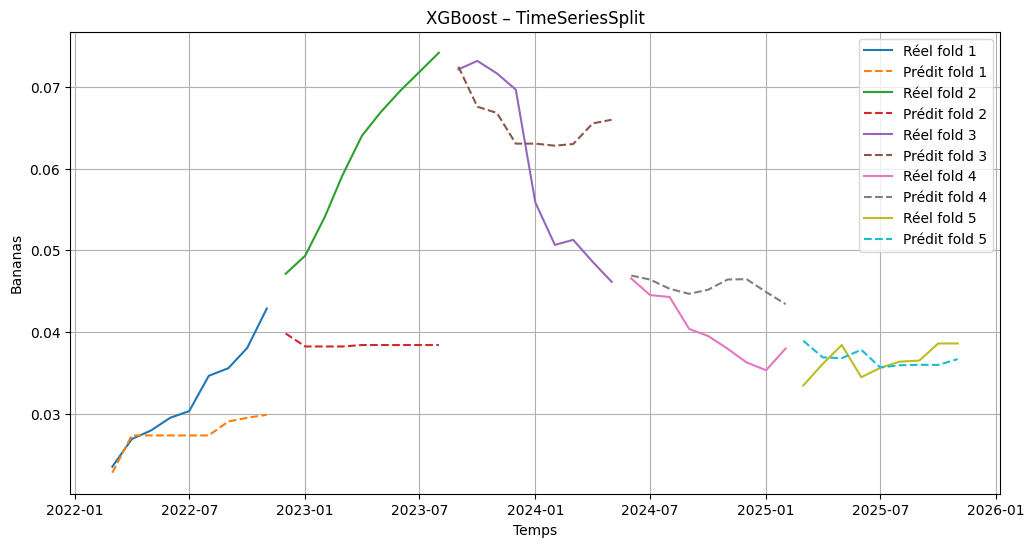

RMSE moyen (TimeSeriesSplit) : 0.0103


In [44]:
#Time serie split
tscv = TimeSeriesSplit(n_splits=5)
rmse_folds = []

plt.figure(figsize=(12,6))

for i, (train_idx, test_idx) in enumerate(tscv.split(X_all)):
    X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
    y_train, y_test = y_all.iloc[train_idx], y_all.iloc[test_idx]
    
    model = XGBRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_folds.append(rmse)
    
    print(f"Fold {i+1} RMSE : {rmse:.4f}")
    
    plt.plot(y_test.index, y_test.values, label=f"Réel fold {i+1}")
    plt.plot(y_test.index, y_pred, '--', label=f"Prédit fold {i+1}")

plt.title("XGBoost – TimeSeriesSplit")
plt.xlabel("Temps")
plt.ylabel("Bananas")
plt.legend()
plt.grid(True)
plt.show()

print(f"RMSE moyen (TimeSeriesSplit) : {np.mean(rmse_folds):.4f}")


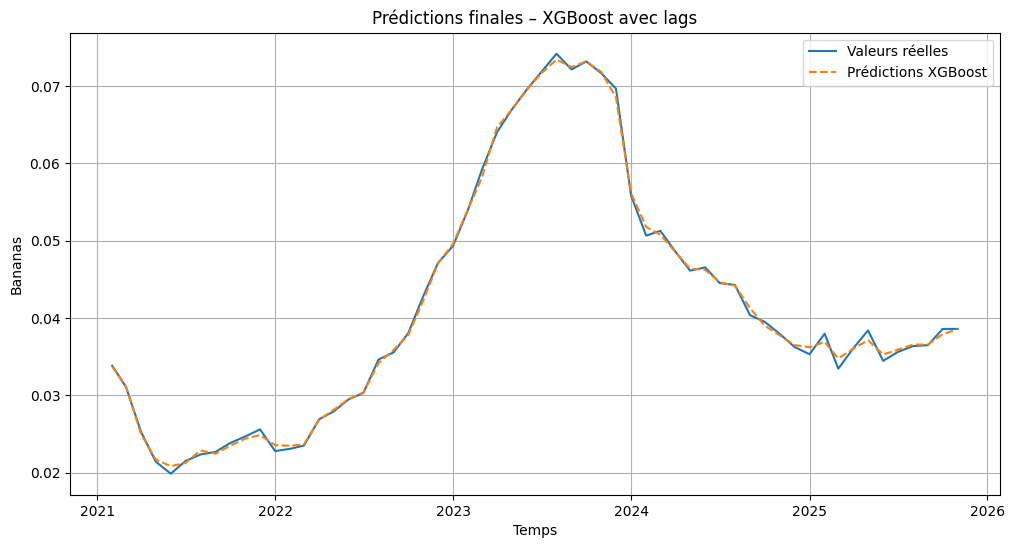

In [45]:
# Final model on all data with lags
model_final = XGBRegressor(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8
)

model_final.fit(X_all, y_all)

y_pred_all = model_final.predict(X_all)

plt.figure(figsize=(12,6))
plt.plot(df_lag.index, y_all, label="Valeurs réelles")
plt.plot(df_lag.index, y_pred_all, '--', label="Prédictions XGBoost")
plt.title("Prédictions finales – XGBoost avec lags")
plt.xlabel("Temps")
plt.ylabel("Bananas")
plt.legend()
plt.grid(True)
plt.show()


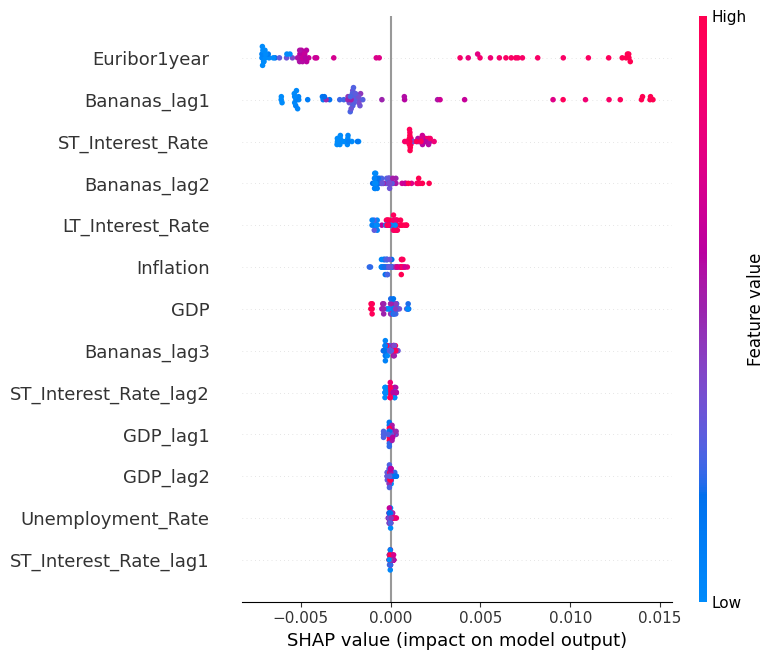

In [46]:
explainer = shap.TreeExplainer(model_final)
shap_values = explainer.shap_values(X_all)
shap.summary_plot(shap_values, X_all)


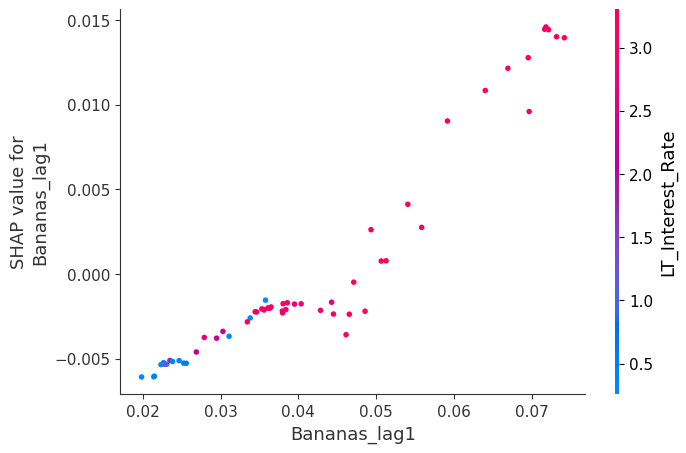

In [47]:
shap.dependence_plot(
    "Bananas_lag1",
    shap_values,   
    X_all
)

### Code to apply the model for our forecast of 2026

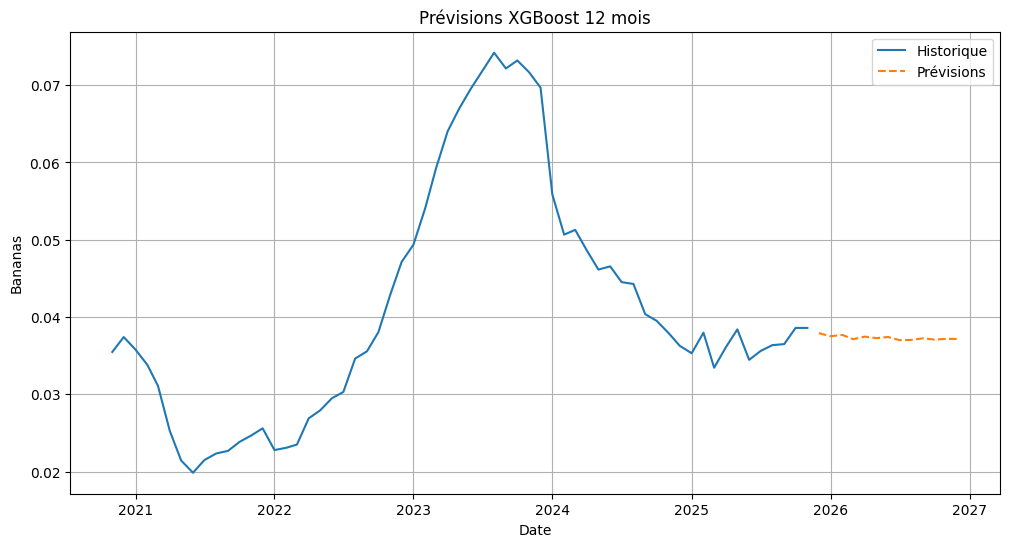

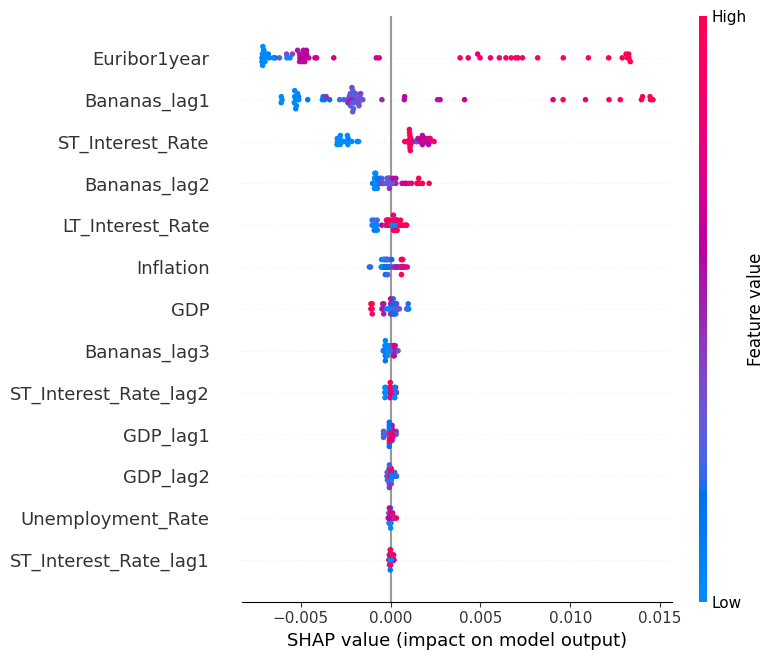

Date
2025-12-01    0.037913
2026-01-01    0.037517
2026-02-01    0.037681
2026-03-01    0.037128
2026-04-01    0.037459
2026-05-01    0.037271
2026-06-01    0.037412
2026-07-01    0.037008
2026-08-01    0.037036
2026-09-01    0.037240
2026-10-01    0.037076
2026-11-01    0.037171
2026-12-01    0.037160
Name: Bananas_pred, dtype: float32

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import shap

# --- 1️⃣ Création des lags ---
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog={}):
    df_lag = df.copy()
    
    # Lags sur la cible
    for lag in lags_target:
        df_lag[f'{target_col}_lag{lag}'] = df_lag[target_col].shift(lag)
    
    # Lags sur features exogènes
    for feature, lags in lags_exog.items():
        for lag in lags:
            df_lag[f'{feature}_lag{lag}'] = df_lag[feature].shift(lag)
    
    return df_lag

lags_target = [1,2,3]
lags_exog = {'ST_Interest_Rate':[1,2], 'GDP':[1,2]}  # exemple

df_full = pd.concat([df_known, df_forecast]).sort_index()
df_full_lag = create_lag_features(df_full, 'Bananas', lags_target, lags_exog)

# --- 2️⃣ Définition des features et target ---
features = (
    ['GDP','Inflation','Unemployment_Rate','LT_Interest_Rate','ST_Interest_Rate','Euribor1year'] +
    [f'Bananas_lag{lag}' for lag in lags_target] +
    [f'{feat}_lag{lag}' for feat, lags in lags_exog.items() for lag in lags]
)

df_train_lag = df_full_lag.loc[df_known.index].dropna()
X_train = df_train_lag[features]
y_train = df_train_lag['Bananas']

# --- 3️⃣ Utiliser le modèle final déjà entraîné ---
# On suppose que model_final a été entraîné précédemment sur X_train et y_train
# model_final.fit(X_train, y_train)  # déjà fait auparavant

# --- 4️⃣ Prédictions itératives sur le futur ---
df_future_preds = df_full_lag.loc[df_forecast.index].copy()
y_pred_future = []

for i, date in enumerate(df_future_preds.index):
    # 1️⃣ Préparer les features
    X_t = df_future_preds.loc[date, features].values.reshape(1, -1)
    
    # 2️⃣ Prédiction avec le modèle final
    y_t = model_final.predict(X_t)[0]
    df_future_preds.loc[date, 'Bananas_pred'] = y_t
    y_pred_future.append(y_t)
    
    # 3️⃣ Mettre à jour les lags pour le mois suivant
    if i+1 < len(df_future_preds):
        next_date = df_future_preds.index[i+1]
        df_future_preds.loc[next_date, 'Bananas_lag1'] = y_t
        df_future_preds.loc[next_date, 'Bananas_lag2'] = df_future_preds.loc[date, 'Bananas_lag1']
        df_future_preds.loc[next_date, 'Bananas_lag3'] = df_future_preds.loc[date, 'Bananas_lag2']

# --- 5️⃣ Visualisation des prévisions ---
plt.figure(figsize=(12,6))
plt.plot(df_known.index, df_known['Bananas'], label='Historique')
plt.plot(df_future_preds.index, df_future_preds['Bananas_pred'], '--', label='Prévisions')
plt.xlabel('Date')
plt.ylabel('Bananas')
plt.title('Prévisions XGBoost 12 mois')
plt.legend()
plt.grid(True)
plt.show()

# --- 6️⃣ SHAP (optionnel pour expliquer le modèle final) ---
explainer = shap.TreeExplainer(model_final)
sample_size = min(500, len(X_train))
X_shap = X_train.sample(sample_size, random_state=42)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap)
df_future_preds['Bananas_pred']


---

---

---

---

## Annexe